**Корнеев Роман Александрович**

*М80-304Б-17*

## Датасет для регрессии

In [1]:
! pip install jupyterthemes -q

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sm

import warnings

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

from sklearn.model_selection import train_test_split


warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style('onedork')

%matplotlib inline

### Импортируем данные

In [3]:
train_df = pd.read_csv("./input/Train.csv")


train_df = train_df.drop(['id'], axis = 1)
train_df[train_df.floor > 5].head(5)

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
7,2011-01-01,410,NaN,7,33,1,0,NaN,0.0,2,...,0,0,0,0,0,0,0,0,0,2736000
8,2011-01-01,196,NaN,6,54,2,1,25.0,NaN,2,...,0,0,0,0,0,0,0,0,0,9047000
11,2011-01-01,214,NaN,8,34,1,0,30.0,NaN,0,...,0,0,0,0,0,0,0,0,0,3035000
12,2011-01-01,259,NaN,11,58,2,0,15.0,1.0,2,...,0,1,0,0,0,0,0,0,0,6652000
16,2011-01-01,601,1.0,10,34,1,1,20.0,NaN,1,...,0,0,0,0,0,0,0,0,0,5265000


### Посмотрим на зависимости между данными

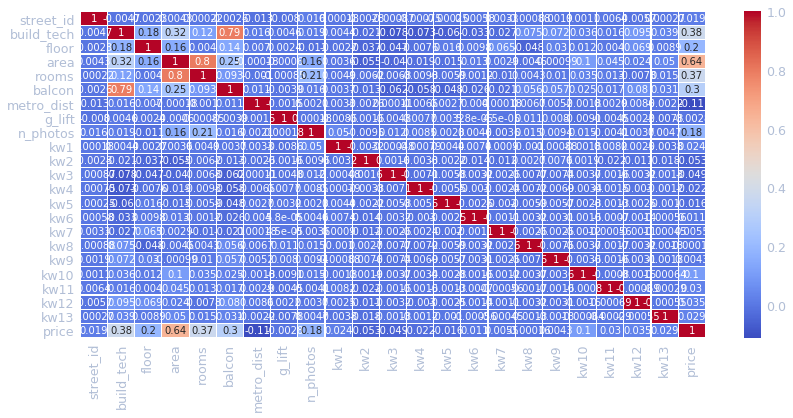

In [4]:
fi = plt.figure(figsize= (14, 6))
ax1 = fi.add_subplot()
#ax1.set_title('Матрица корелляции')
sns.heatmap(train_df[train_df.build_tech.notna()].corr(), annot=True, cmap = "coolwarm", linewidth = 0.1, ax = ax1)

In [5]:
train_df.area.unique()

array([ 67,  45,  61,  51,  60,  34,  36,  33,  54,  43,  31,  58,  32,
        35,  50,  44,  48,  59,  52,  47, 125,  88, 168,  65, 167,  46,
        71,  63,  55,  57,  90,  41,  62,  38,  75,  70,  40, 183,  56,
       166,  39,  42,  98,  74,  53,  37,  29,  73, 104, 142,  66,  72,
        95,  91,  49,  64,  87, 105,  89,  30, 110,  86, 163,  97,  99,
        69, 123,  76, 112, 124, 109,  93, 143,  68,  77, 173, 153, 185,
       181, 215, 127, 145,  92, 102, 184, 154, 101,  94, 108, 111, 152,
       182, 144, 174,  96, 107, 103, 175, 165, 126, 216, 164, 155, 100,
       217, 156, 171, 141, 161, 169, 213, 162])

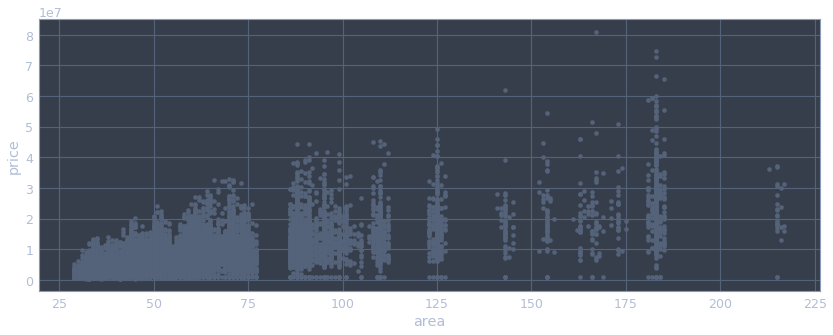

In [6]:
train_df.plot.scatter(x = 'area', y = 'price', figsize = (14, 5))

### Уберем очевидные выбросы

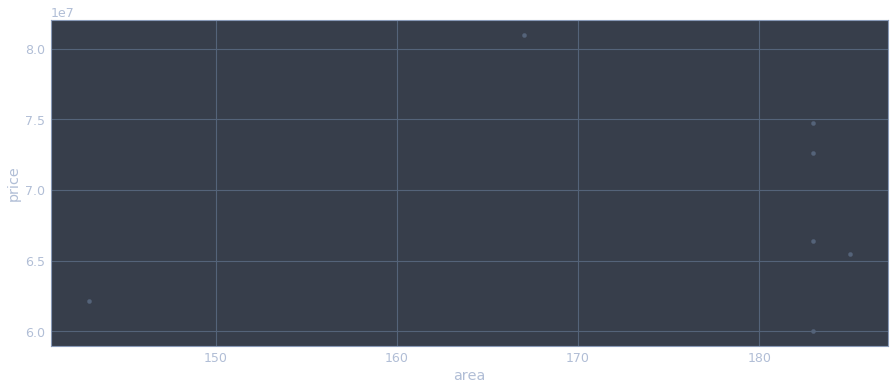

In [7]:
train_df[train_df.price > 60000000].plot.scatter(x = 'area', y = 'price', figsize = (15, 6))

In [8]:
train_df.price.max()

80979000

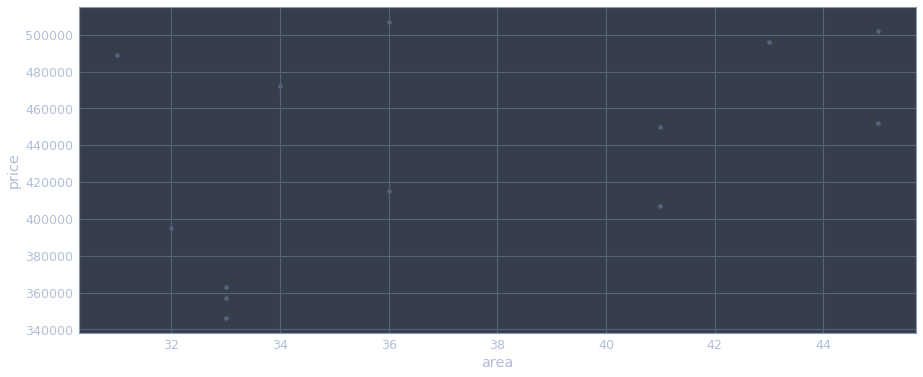

In [9]:
train_df[train_df.price < 550000].plot.scatter(x = 'area', y = 'price', figsize = (15, 6))

In [10]:
train_df = train_df[train_df.price < 60000000] 
train_df = train_df[train_df.price > 550000]
#train_df = train_df[train_df.price > ]

In [11]:
train_df.price.min()

560000

### Код для генерации фичи - количества ключевых слов

In [12]:
new_feature = train_df[['kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', \
                        'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']].sum(axis = 1)
train_df['n_kw'] = new_feature

### Парсим дату и создаем новые фичи

Достаем месяц и год, однако я решил, что информация о годе избыточна

In [13]:
seria = train_df.date.str.split(pat = '-')
#train_df['year'] = seria.str[0]
train_df['mounth'] = seria.str[1]


train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        99980 non-null  object 
 1   street_id   99980 non-null  int64  
 2   build_tech  70003 non-null  float64
 3   floor       99980 non-null  int64  
 4   area        99980 non-null  int64  
 5   rooms       99980 non-null  int64  
 6   balcon      99980 non-null  int64  
 7   metro_dist  94827 non-null  float64
 8   g_lift      70080 non-null  float64
 9   n_photos    99980 non-null  int64  
 10  kw1         99980 non-null  int64  
 11  kw2         99980 non-null  int64  
 12  kw3         99980 non-null  int64  
 13  kw4         99980 non-null  int64  
 14  kw5         99980 non-null  int64  
 15  kw6         99980 non-null  int64  
 16  kw7         99980 non-null  int64  
 17  kw8         99980 non-null  int64  
 18  kw9         99980 non-null  int64  
 19  kw10        99980 non-nul

### Создание фичи проверяющей есть ли несфотографированные комнаты

In [14]:
new_feature = train_df.n_photos.copy()
new_feature[train_df.n_photos < train_df.rooms] = 0
new_feature[train_df.n_photos >= train_df.rooms] = 1
train_df['rooms_with_photo'] = new_feature

train_df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw8,kw9,kw10,kw11,kw12,kw13,price,n_kw,mounth,rooms_with_photo
0,2011-01-01,511,1.0,5,67,2,1,NaN,1.0,1,...,0,0,0,0,0,0,18473000,0,01,0
1,2011-01-01,299,0.0,3,45,2,0,20.0,0.0,0,...,0,0,0,0,0,0,4157000,0,01,0
2,2011-01-01,217,NaN,1,61,3,1,10.0,1.0,1,...,0,0,0,0,0,0,4530000,1,01,0
3,2011-01-01,212,NaN,2,51,2,1,15.0,0.0,2,...,0,0,0,0,0,0,7981000,1,01,1
4,2011-01-01,160,1.0,3,60,3,1,25.0,0.0,1,...,0,0,0,0,0,0,11888000,1,01,0


### Создаем новую фичу, объединяющую данные о районе и улице

А также определяем столбцы для кодирования

In [15]:
LE_cols = ['date', 'mounth', 'place']

train_df['place'] = 1000 * train_df.area + train_df.street_id

train2_df = train_df.copy()
train2_df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw9,kw10,kw11,kw12,kw13,price,n_kw,mounth,rooms_with_photo,place
0,2011-01-01,511,1.0,5,67,2,1,NaN,1.0,1,...,0,0,0,0,0,18473000,0,01,0,67511
1,2011-01-01,299,0.0,3,45,2,0,20.0,0.0,0,...,0,0,0,0,0,4157000,0,01,0,45299
2,2011-01-01,217,NaN,1,61,3,1,10.0,1.0,1,...,0,0,0,0,0,4530000,1,01,0,61217
3,2011-01-01,212,NaN,2,51,2,1,15.0,0.0,2,...,0,0,0,0,0,7981000,1,01,1,51212
4,2011-01-01,160,1.0,3,60,3,1,25.0,0.0,1,...,0,0,0,0,0,11888000,1,01,0,60160


### Кодируем

In [16]:
encoder = LabelEncoder()

for col in LE_cols:
    print(f"Encoding {col}")
    train2_df[col] = encoder.fit_transform(train2_df[col])

Encoding date
Encoding mounth
Encoding place


### Заполняем пропуски в данных

In [17]:
msk = train2_df.g_lift.isnull()
msk2 = train2_df.floor > 5
msk3 = train2_df.g_lift.notnull()
train2_df.g_lift[msk] = 0
train2_df.g_lift[msk] = train2_df.g_lift[msk3].mean()

msk = train2_df.metro_dist.isnull()
msk3 = train2_df.metro_dist.notnull()
new_feature = train2_df.metro_dist.copy()
new_feature[msk] = 1
new_feature[msk3] = 0
train2_df.metro_dist[msk] = train2_df.metro_dist[msk3].mean()
train2_df['not_metro'] = new_feature
# full_df.head(20)

train2_df.build_tech[train2_df.balcon != 0] = train2_df.balcon[train2_df.balcon != 0]
train2_df.build_tech[train2_df.build_tech.isnull()] = \
train2_df.build_tech[train2_df.balcon == 0 & train2_df.build_tech.notnull()].mean()

### Генерируем статисткики - фичи
Сгенерируем самые обыкновенные фичи-статистики и добавим их в датасет.

In [18]:

train2_df['mean_md'] = train2_df['area'].map(train2_df.groupby('area')['metro_dist'].mean())

train2_df['max_area_p'] = train2_df.price.max()
train2_df['min_area_p'] = train2_df.price.min()
train2_df['mean_area_p'] = train2_df.price.mean()

train2_df.mean_area_p[train2_df.area < 214] = \
    train2_df.area[train2_df.area < 214].map(train2_df.groupby('area')['price'].mean())


train2_df['mean_rooms_p'] = train2_df['rooms'].map(train2_df.groupby('rooms')['price'].mean())

train2_df['mean_floor_p'] = train2_df['floor'].map(train2_df.groupby('floor')['price'].mean())


train2_df = train2_df[train2_df.price.notnull()]

train2_df['mean_mounth_p'] = train2_df['mounth'].map(train2_df.groupby('mounth')['price'].mean())
train2_df['max_mounth_p'] = train2_df['mounth'].map(train2_df.groupby('mounth')['price'].max())
train2_df['min_mounth_p'] = train2_df['mounth'].map(train2_df.groupby('mounth')['price'].min())

In [19]:
# train2_df.drop("g_lift", axis = 1, inplace = True)
# test2_df.drop("g_lift", axis = 1, inplace = True)

### Получаем целевой столбец

In [20]:
target_col = train2_df.price
train2_df.drop('price', axis = 1, inplace=True)

In [21]:
train2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              99980 non-null  int64  
 1   street_id         99980 non-null  int64  
 2   build_tech        99980 non-null  float64
 3   floor             99980 non-null  int64  
 4   area              99980 non-null  int64  
 5   rooms             99980 non-null  int64  
 6   balcon            99980 non-null  int64  
 7   metro_dist        99980 non-null  float64
 8   g_lift            99980 non-null  float64
 9   n_photos          99980 non-null  int64  
 10  kw1               99980 non-null  int64  
 11  kw2               99980 non-null  int64  
 12  kw3               99980 non-null  int64  
 13  kw4               99980 non-null  int64  
 14  kw5               99980 non-null  int64  
 15  kw6               99980 non-null  int64  
 16  kw7               99980 non-null  int64 

### Нормализуем данные

Воспользуемся minmax нормализацией:

In [22]:
# NORMALISATION

train2_df = \
    (train2_df - train2_df.min(axis = 0)) / (train2_df.max(axis = 0) - train2_df.min(axis = 0))

train2_df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,not_metro,mean_md,max_area_p,min_area_p,mean_area_p,mean_rooms_p,mean_floor_p,mean_mounth_p,max_mounth_p,min_mounth_p
0,0.0,0.761550,0.5,0.166667,0.202128,0.2,0.5,0.728152,1.0,0.1,...,1.0,0.765610,NaN,NaN,0.223312,0.075005,0.042082,0.0,0.73462,0.435185
1,0.0,0.445604,0.0,0.083333,0.085106,0.2,0.0,0.666667,0.0,0.0,...,0.0,0.730768,NaN,NaN,0.049051,0.075005,0.082659,0.0,0.73462,0.435185
2,0.0,0.323398,0.5,0.000000,0.170213,0.4,0.5,0.333333,1.0,0.1,...,0.0,0.732325,NaN,NaN,0.112927,0.124952,0.000000,0.0,0.73462,0.435185
3,0.0,0.315946,0.5,0.041667,0.117021,0.2,0.5,0.500000,0.0,0.2,...,0.0,0.731759,NaN,NaN,0.082422,0.075005,0.076705,0.0,0.73462,0.435185
4,0.0,0.238450,0.5,0.083333,0.164894,0.4,0.5,0.833333,0.0,0.1,...,0.0,0.731403,NaN,NaN,0.109974,0.124952,0.082659,0.0,0.73462,0.435185


## Test Train разбиение


***Train Test Split*** разбивает данные на обучающую и тетовую подвыборку.


In [25]:
X_train,X_test,y_train,y_test = \
    train_test_split(train2_df,target_col,test_size=0.25,random_state=42)